In [1]:
#import all necessary libraries
import pandas as pd
import pandas_ta as ta
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

from scipy import stats
import seaborn as sns
sns.set_style('whitegrid')

from datetime import datetime
import yfinance as yf

from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# This can be changed to any other stock (user input)
stock_symbol = 'AAPL'

#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,start=start, end=end,actions=False)

print(data.tail(10))

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-08-12  216.070007  219.509995  215.600006  217.529999  217.529999   
2024-08-13  219.009995  221.889999  219.009995  221.270004  221.270004   
2024-08-14  220.570007  223.029999  219.699997  221.720001  221.720001   
2024-08-15  224.600006  225.350006  222.759995  224.720001  224.720001   
2024-08-16  223.919998  226.830002  223.649994  226.050003  226.050003   
2024-08-19  225.720001  225.990005  223.039993  225.889999  225.889999   
2024-08-20  225.770004  227.169998  225.449997  226.509995  226.509995   
2024-08-21  226.520004  227.979996  225.050003  226.399994  226.399994   
2024-08-22  227.789993  228.339996  223.899994  224.529999  224.529999   
2024-08-23  225.658997  228.220001  224.339996  226.839996  226.839996   

              Volume  
Date                  
2024-08-12  38028100  
2024-08-13  44155300  
2024-08-14  4196060

In [3]:
# Ensure the data is numeric
numeric_data = data.select_dtypes(include=[np.number])

# Calculate z-scores
z_scores = stats.zscore(numeric_data)

# Identify outliers
outliers = (np.abs(z_scores) > 3)
            
# Print outliers
print("Outlier rows (True indicates an outlier):")
print(outliers)

Outlier rows (True indicates an outlier):
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2019-08-23  False  False  False  False      False   False
2019-08-26  False  False  False  False      False   False
2019-08-27  False  False  False  False      False   False
2019-08-28  False  False  False  False      False   False
2019-08-29  False  False  False  False      False   False
...           ...    ...    ...    ...        ...     ...
2024-08-19  False  False  False  False      False   False
2024-08-20  False  False  False  False      False   False
2024-08-21  False  False  False  False      False   False
2024-08-22  False  False  False  False      False   False
2024-08-23  False  False  False  False      False   False

[1259 rows x 6 columns]


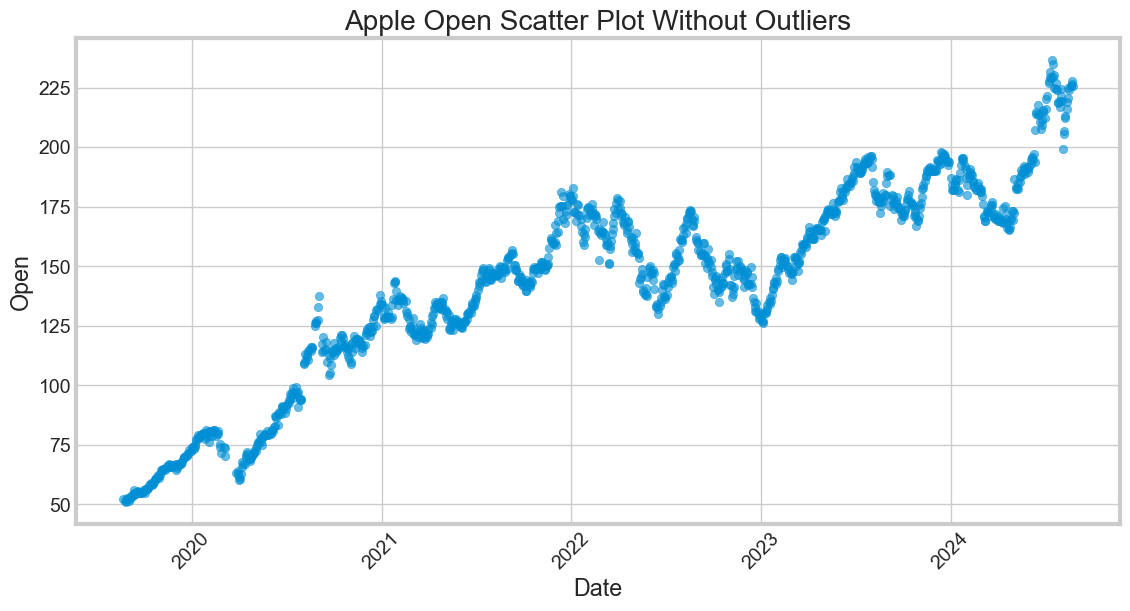

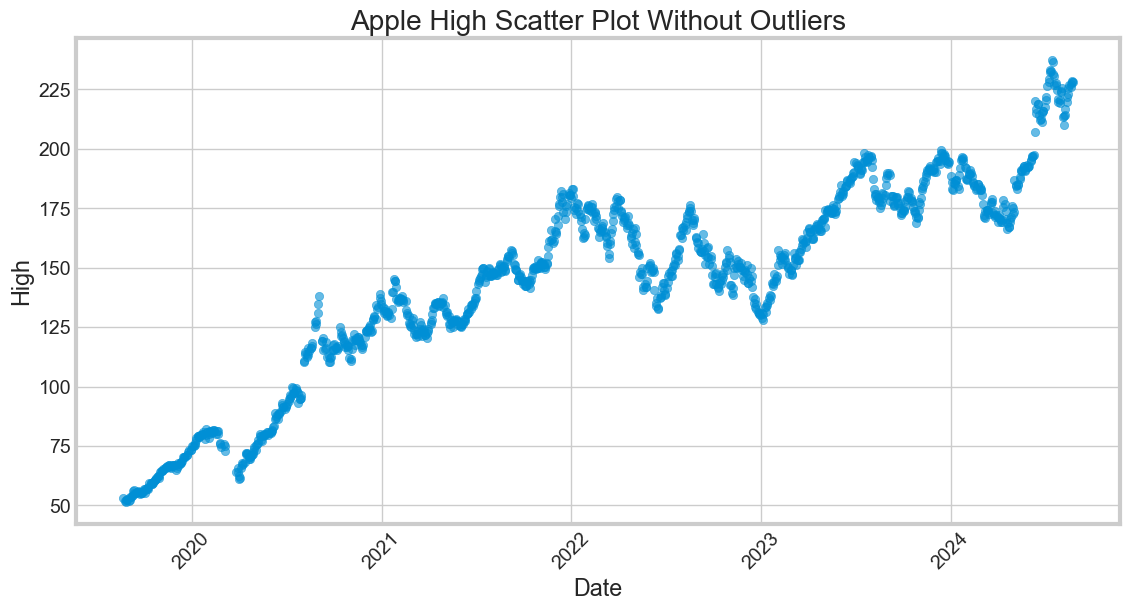

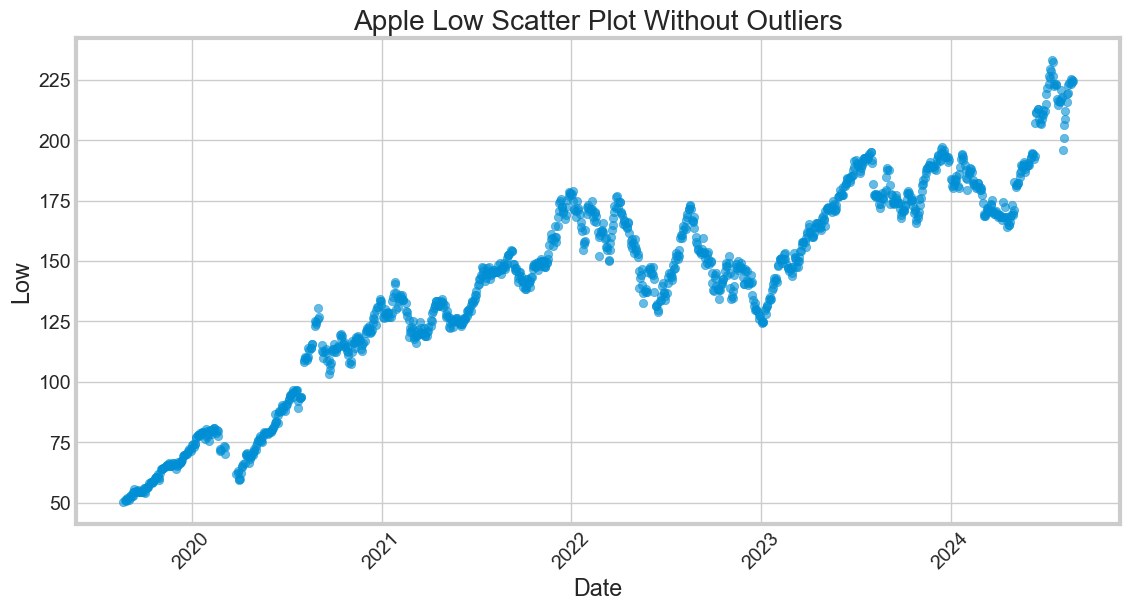

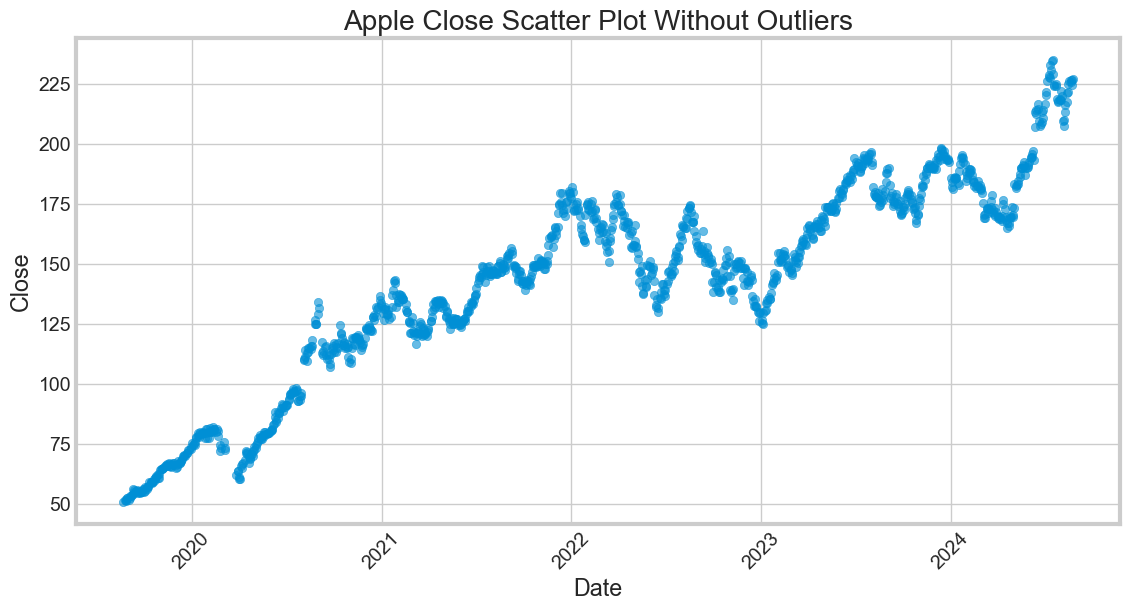

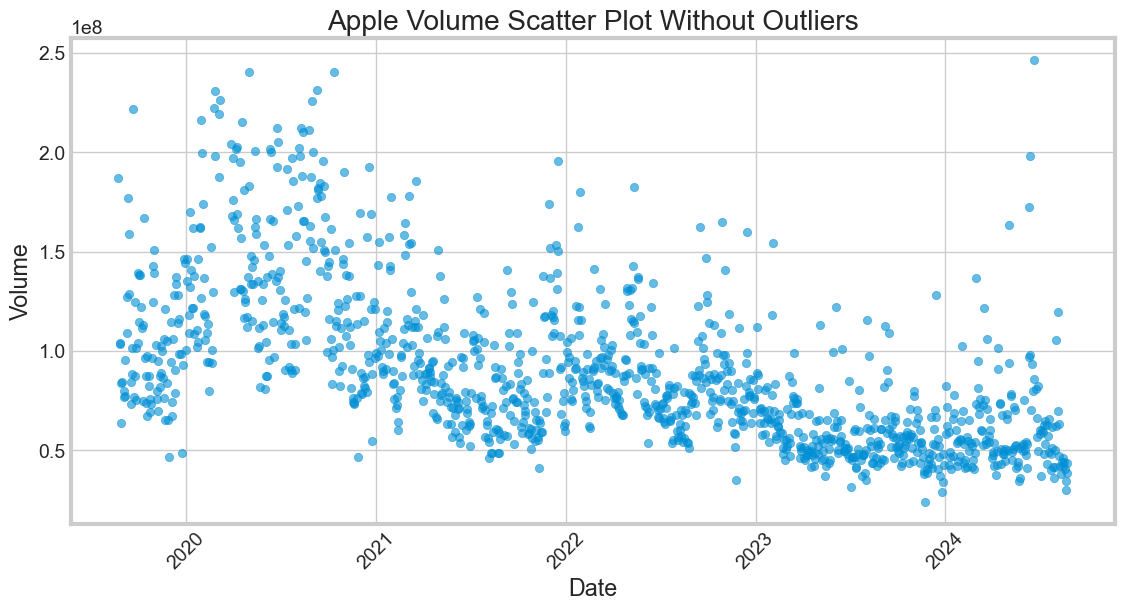

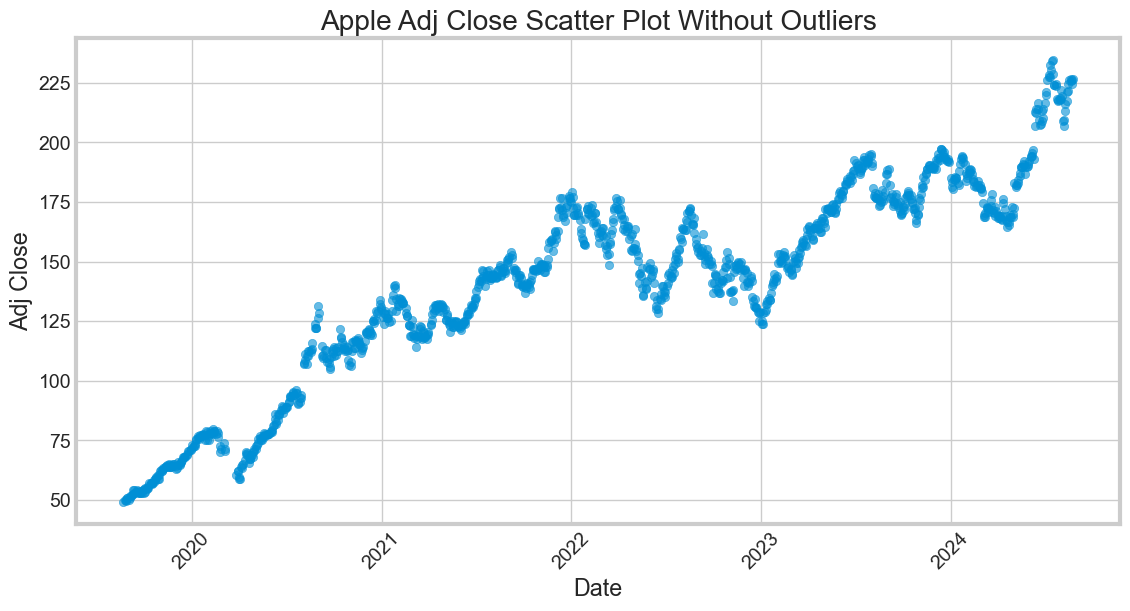

In [4]:
columns_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
data = data[columns_to_keep]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

#handle outliers with a method
def remove_outliers(df):
    z_scores = stats.zscore(df.select_dtypes(include=[np.number]))
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return df[filtered_entries]

#use the method for the company
data_cleaned=remove_outliers(data)

numerical_columns = data_cleaned.select_dtypes(include=[np.number]).columns

#show the results
for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    plt.scatter(data_cleaned.index, data_cleaned[column], alpha=0.6)
    plt.title(f'Apple {column} Scatter Plot Without Outliers')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.show()
#print(data_cleaned.tail(10))

In [7]:
#Set Target Variable
#Can filter close either or way
#output_var = pd.DataFrame(data_cleaned, columns=['Close']) 
data_cleaned = data
Target = data_cleaned.filter(['Close'])

#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']
Target.tail

<bound method NDFrame.tail of                  Close
Date                  
2019-08-23   50.660000
2019-08-26   51.622501
2019-08-27   51.040001
2019-08-28   51.382500
2019-08-29   52.252499
...                ...
2024-08-19  225.889999
2024-08-20  226.509995
2024-08-21  226.399994
2024-08-22  224.529999
2024-08-23  226.839996

[1259 rows x 1 columns]>

In [8]:
#Scaling
scaler = MinMaxScaler(feature_range= (0,1))
feature_transform = scaler.fit_transform(data_cleaned[features])
feature_transform = pd.DataFrame(columns = features, data = feature_transform, index = data_cleaned.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-08-23,0.007185,0.008517,0.000000,0.405563
2019-08-26,0.002373,0.001978,0.005551,0.199090
2019-08-27,0.005069,0.003808,0.003459,0.197397
2019-08-28,0.000000,0.000000,0.003172,0.098660
2019-08-29,0.005931,0.004844,0.007739,0.148868


In [9]:
#Splitting to Training, Testing and Validation set
timesplit = TimeSeriesSplit(n_splits=10)

for train_index, test_index in timesplit.split(feature_transform):
    # Define the training and testing sets
    X_train = feature_transform[:len(train_index)]
    X_test = feature_transform[len(train_index): (len(train_index) + len(test_index))]
    y_train = Target[:len(train_index)].values.ravel()
    y_test =Target[len(train_index): (len(train_index) + len(test_index))].values.ravel()
    
     # Further split the training set into training and validation sets
    
    split_ratio = 0.8 # Example: 80% of the training data for training, 20% for validation
    split_point = int(len(X_train) * split_ratio)
    
    X_train_temp = X_train[:split_point]
    X_val = X_train[split_point:]
    
    y_train_final = y_train[:split_point]
    y_val = y_train[split_point:]    

# The Data is now split into training, validation and testing sets  
print("Shape of feature_transform:", feature_transform.shape)
    
print("Shape after split - X_train:", X_train.shape)
print("Shape after split - X_val and X_train_temp:", X_val.shape, X_train_temp.shape)
print("Shape after split - X_test:", X_test.shape)

Shape of feature_transform: (1259, 4)
Shape after split - X_train: (1145, 4)
Shape after split - X_val and X_train_temp: (229, 4) (916, 4)
Shape after split - X_test: (114, 4)


In [10]:
# Process the data for LSTM, turn them into np arrays
X_train_temp = np.array(X_train_temp)
X_val = np.array(X_val)
X_test = np.array(X_test)


# Reshape them into 3D format
X_train_final = X_train_temp.reshape((X_train_temp.shape[0], 1, X_train_temp.shape[1]))
X_val_final = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_final = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('Final X training set: ', X_train_final.shape)
print("Final X validation set shape: ", X_val_final.shape)
print("Final X test set shape: ", X_test_final.shape)
print(X_train_final.shape[2])

Final X training set:  (916, 1, 4)
Final X validation set shape:  (229, 1, 4)
Final X test set shape:  (114, 1, 4)
4


In [23]:
model = Sequential()
model.add(Input(shape=(1,X_train_final.shape[2])))
model.add(LSTM(128, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(LSTM(64, return_sequences = True, activation = 'relu'))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(25))

model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='MeanSquaredError',metrics=['MeanSquaredError'])
# Ensure model is built
model.build((None, 1, X_train_final.shape[2]))

early_stopping = EarlyStopping(monitor='val_MeanSquaredError', patience=10, restore_best_weights=True,mode='min')

plot_model(model, show_shapes=True, show_layer_names=True)

history =model.fit(X_train_final, y_train_final, batch_size = 64, epochs =100, validation_data=(X_val_final, y_val),callbacks=[early_stopping],verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - MeanSquaredError: 17098.3359 - loss: 17098.3359 - val_MeanSquaredError: 33141.2070 - val_loss: 33141.2070
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - MeanSquaredError: 16506.1426 - loss: 16506.1426 - val_MeanSquaredError: 32935.0078 - val_loss: 32935.0078
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - MeanSquaredError: 16285.2285 - loss: 16285.2285 - val_MeanSquaredError: 32173.9688 - val_loss: 32173.9688
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - MeanSquaredError: 16258.3223 - loss: 16258.3223 - val_MeanSquaredError: 27378.7891 - val_loss: 27378.7891
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - MeanSquaredError: 11816.5898 - loss: 11816.5898 - val_MeanSquaredError: 493.9070 - val_loss: 493.9070
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - MeanSquaredError: 1625.2424 - loss: 1625.2424 - val_MeanSquaredError: 198.5054 - val_loss: 198.5054
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

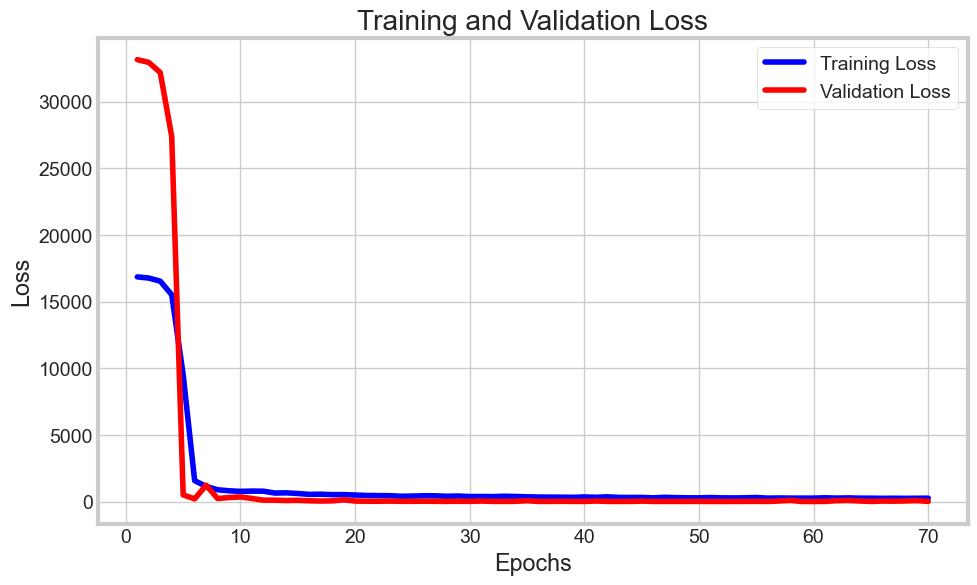

In [24]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
history_dict = history.history

# Extract loss values
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_pred = model.predict(X_test_final)

1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D23358B060> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step


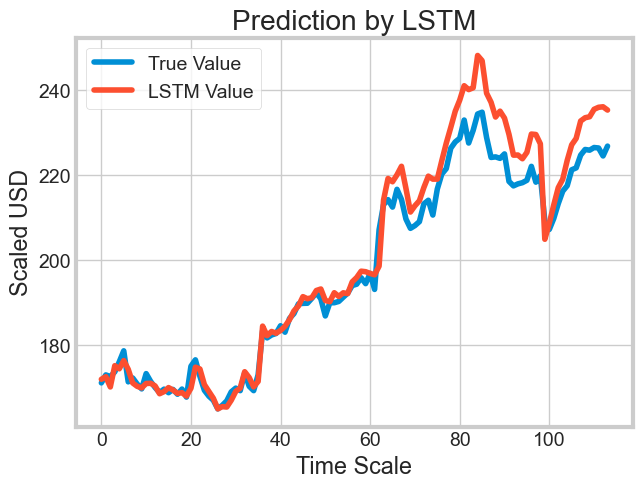

In [26]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

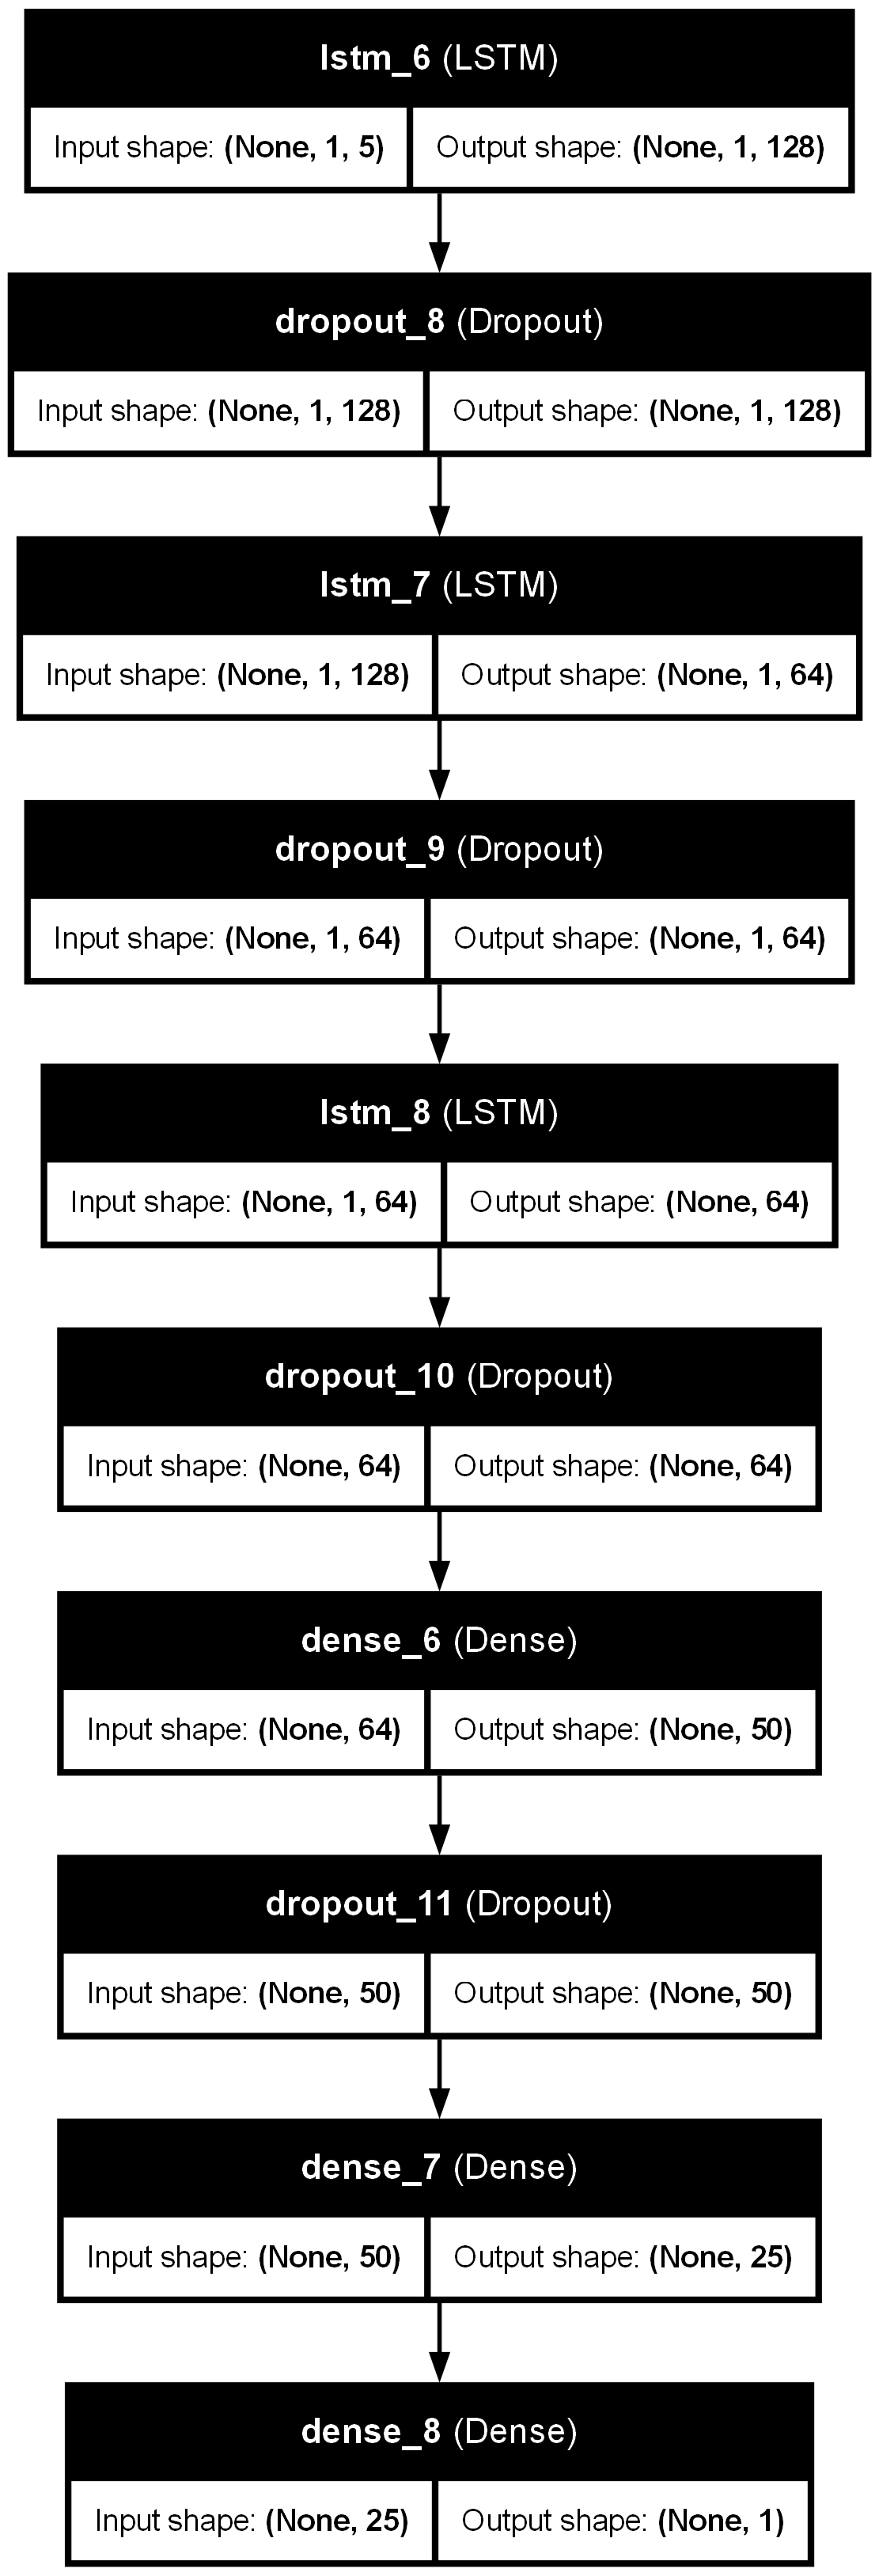

In [42]:
plot_model(model, show_shapes=True, show_layer_names=True)